In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import g
from scipy.optimize import curve_fit

In [ ]:
##constants

sigma_0 = 1000              #density water
sigma = 500                 #density ship

R = 10                      #Radius of ship
A_s = 1/2 * np.pi * R**2    #Area of ship
m = A_s * sigma             #Mass of ship

I_C = 1/2 * m * R**2 * (1 - 32 / (9 * np.pi**2))        #Moment of inertia about C

h = 4 * R / (3 * np.pi)     #distance from M to C

omega_prime = np.sqrt(m * g * h / I_C)

def ym_0(beta):             #eq. 4a
    return R * np.cos(beta/2)

def yc_0(beta):             #eq. 4b
    return ym_0(beta) - h

def yb_0(beta):             #eq. 4c
    return R * np.cos(beta/2) - 4 * R * np.sin(beta/2)**3 / (3 * (beta - np.sin(beta)))

def yd_0(beta):             #eq. 4d
    return ym_0(beta) - R

def Ymb_0(gamma):
    return R * 4 * np.sin(gamma/2)**3 / (3 * (gamma - np.sin(gamma)))

def A(angle):               #Area of immersed object
    return 1/2 * R**2 * (angle - np.sin(angle))


In [ ]:
##task 1a) solve eq. 1 ==> finding beta

#using fixedpoint iteration

#eq. 1 ==> beta = np.pi * sigma / sigma_0 + np.sin(beta)

def g_beta(beta):
    return np.pi * sigma / sigma_0 + np.sin(beta)

def fixedpoint(g, beta0 = np.pi / 2, tol=1.e-8, max_iter=1000):

    beta = beta0

    for k in range(max_iter):        
        beta_old = beta                        # Store old values for error estimation 
        beta = g(beta)                         # The iteration
        err = abs(beta-beta_old)               # Error estimate
       

        if err < tol:                    # The solution is accepted 
            break

    return beta, k+1

beta, numberOfSteps = fixedpoint(g_beta)

print(f"beta = {np.degrees(beta):14.10f} ")

beta = 132.3464590307 


In [ ]:
##task 1b) solve eq. 4a - 4c

ym_initial = ym_0(beta)
yc_initial = yc_0(beta)
yb_initial = yb_0(beta)
yd_initial = yd_0(beta)


In [ ]:
##task 1c)
def f_sin(t, omega_vec):
    return np.array([omega_vec[1], -F_B / I_C * h * np.sin(omega_vec[0])])

In [ ]:
##Forces used in 1c)
F_G = -m * g
F_B = A(beta) * sigma_0 * g

In [ ]:
##task 1d) Solve 1c) through Eulers method
##Initial value:

theta_0 = np.radians(20)
omega_0 = 0

t_0 = 0
t_end = 20
s = 10e-4

def euler(f, t, omega_vec, s):
    # One step of the Euler method
    omega_vec_next = omega_vec + s * f(t, omega_vec)
    t_next = t + s
    return t_next, omega_vec_next

def ode_solver(f, t0, tend, omega_vec_0, s, method = euler):
  
    #Initializing:
    omega_vec_num = np.array([omega_vec_0])    # Array for the solution of omega_vec 
    t_num = np.array([t0])                     # Array for the t-values

    tn = t0                                    # Running values for t and array of omega_vec
    omega_vec_n = omega_vec_0 

    # Main loop
    while tn < tend:# - 1.e-10:                  # Buffer for truncation errors  
        if tn + s > tend:
            s = tend - tn
         
        tn, omega_vec_n = method(f, tn, omega_vec_n, s)    # Do one step by the given methode
        
        # Extend the arrays for t and omega_vec
        omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
        t_num = np.append(t_num,tn)
        
    #print(t_num[-1])
    return t_num, omega_vec_num


t_euler, omega_vec_euler = ode_solver(f_sin, t_0, t_end, np.array([theta_0, omega_0]), s)

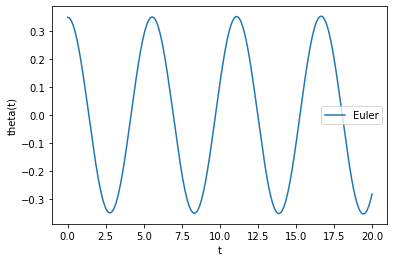

In [ ]:


# Plot of the numerical solution
plt.plot(t_euler, np.transpose(omega_vec_euler)[0], '-')


plt.xlabel('t')
plt.ylabel(f'theta(t)')
plt.legend(['Euler']);

plt.show()

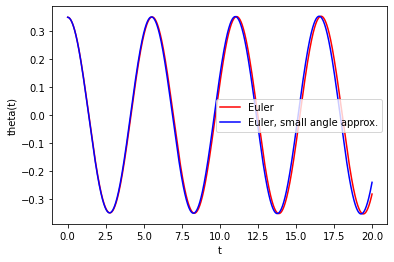

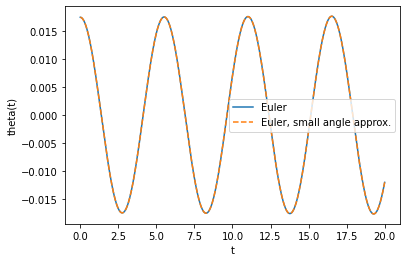

In [ ]:
##task 1e) solve eq.10 = small angle approx to the equation solved in 1d)

def f_smallAngle(t, omega_vec):
    return np.array([omega_vec[1], -F_B / I_C * h * omega_vec[0]])


t_smallAngle, omega_vec_smallAngle = ode_solver(f_smallAngle, t_0, t_end, np.array([theta_0, omega_0]), s)

plt.figure()
plt.plot(t_euler, np.transpose(omega_vec_euler)[0], 'r')
plt.plot(t_smallAngle, np.transpose(omega_vec_smallAngle)[0], 'b')

plt.xlabel('t')
plt.ylabel('theta(t)')
plt.legend(['Euler', 'Euler, small angle approx.']);

plt.show()

##initial value theta_0 = 1

new_theta_0 = np.radians(1)

t_new, omega_vec_new = ode_solver(f_sin, t_0, t_end,  np.array([new_theta_0, omega_0]), s)
t_smallAngle_new, omega_vec_smallAngle_new = ode_solver(f_smallAngle, t_0, t_end,  np.array([new_theta_0, omega_0]), s)

plt.figure()
plt.plot(t_new, np.transpose(omega_vec_new)[0],) 
plt.plot(t_smallAngle, np.transpose(omega_vec_smallAngle_new)[0], '--')

plt.xlabel('t')
plt.ylabel('theta(t)')
plt.legend(['Euler', 'Euler, small angle approx.']);

plt.show()

##We observe that the plot for theta_0 = 1 is better than the plot for theta_0 = 20. The small angle approximation is only valid 
##for values below 1 rad, 20 degrees is closer to 1 rad than 1 degree.

In [ ]:
##task 1f) RK4 implementation

def RK4(f, t, omega_vec, s):
    k1 = f(t, omega_vec)
    k2 = f(t + s/2, omega_vec + s/2 * k1)
    k3 = f(t + s/2, omega_vec + s/2 * k2)
    k4 = f(t + s, omega_vec + s * k3)
    
    omega_vec_next = omega_vec + s/6 * (k1 + 2*k2 + 2*k3 + k4)
    t_next = t + s

    return t_next, omega_vec_next 



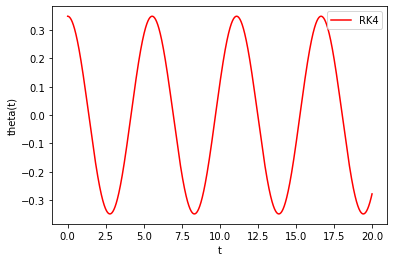

In [ ]:
t_RK4, omega_vec_RK4 = ode_solver(f_sin, t_0, t_end, np.array([theta_0, omega_0]), s, RK4)

plt.figure()
plt.plot(t_RK4, np.transpose(omega_vec_RK4)[0], 'r')


plt.xlabel('t')
plt.ylabel('theta(t)')
plt.legend(['RK4']);

plt.show()

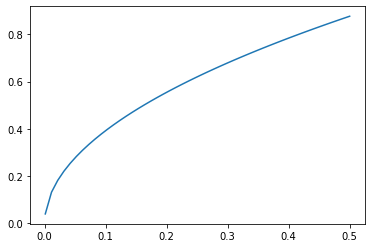

In [ ]:
h = 4 * R / (3 * np.pi)

def step(Tol):
    return  np.sqrt(2 * Tol * I_C/(F_B * h))

a = np.linspace(0.001, 0.5)

plt.figure()
plt.plot(a, step(a))
plt.show()

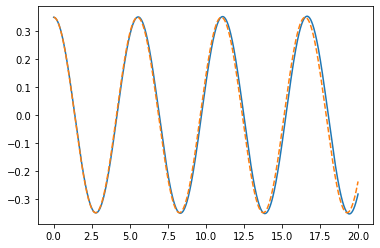

-0.0449852313224019
[ 0.34906585  0.34906562  0.34906494 ... -0.23807199 -0.23778063
 -0.23748897]


In [ ]:
##task 1g) testen av analytisk funksjon mot numerisk(euler) 

def f_analytic(x):
    c = np.sqrt(F_B * h / I_C) 
    #print(c) ###Helt random va verdien på c lik 0.05 også etter æ kjørt notebooken så ble den 1.14 #sus
    return np.pi/9 * np.cos(c*x)

plt.plot(t_euler, np.transpose(omega_vec_euler)[0], '-')
plt.plot(t_euler, f_analytic(t_euler), '--')

plt.show()

print(np.transpose(omega_vec_euler)[0][-1] - f_analytic(t_euler)[-1])


def theta_analytic(t, theta_0, omega_0):
    return theta_0 * np.cos(omega_prime * t) + omega_0 / omega_prime * np.sin(omega_prime * t)

theta_analytic_RK4 = theta_analytic(t_RK4, theta_0, omega_0)
theta_analytic_euler = theta_analytic(t_euler, theta_0, omega_0)

print(theta_analytic_euler)

In [ ]:
def error(method, s_array, t0, tend, theta_0, omega_0):
    errors = np.zeros(len(s_array))
    plot = False

    for i in range(len(s_array)):
        t, theta = ode_solver(f_sin, t0, tend, np.array([theta_0, omega_0]), s_array[i], method)
        theta_thilde = theta_analytic(t, theta_0, omega_0)
        if plot:
            plt.figure()
            plt.plot(t[10:-1], np.transpose(theta)[0][10:-1], label='euler')
            plt.plot(t[10:-1], theta_thilde[10:-1], '--', label='analytic')
            plt.legend()
            plt.show()
        errors[i] = abs(theta_thilde - np.transpose(theta)[0])[-1]

    return errors

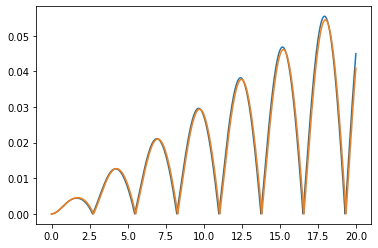

In [ ]:
plt.figure()
plt.plot(t_euler, abs(theta_analytic_euler - np.transpose(omega_vec_euler)[0]))
plt.plot(t_RK4, abs(theta_analytic_RK4 - np.transpose(omega_vec_RK4)[0]))
plt.show()


1.1149671282723705
3.0462651620539893


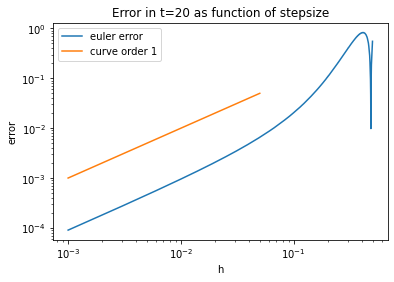

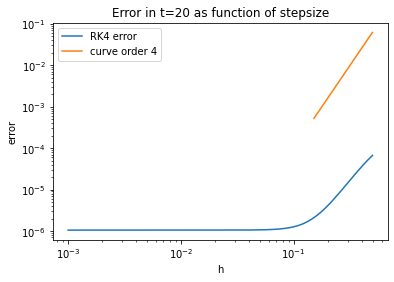

In [ ]:

s = 10**(-3)
s_array = np.arange(0.001,0.4,s)

t_0 = 0
t_end = 20
theta_0 = 0.01
omega_0 = 0
h = 4 * R / (3 * np.pi)

errors_RK4 = error(RK4, s_array, t_0, t_end, theta_0, omega_0)
errors_euler = error(euler, s_array, t_0, t_end, theta_0, omega_0)

def func(x, a, b):
    return a * x + b

error_euler_slope = curve_fit(func, np.log(s_array[:50]), np.log(errors_euler[:50]))
error_RK4_slope = curve_fit(func, np.log(s_array[150:-1]), np.log(errors_RK4[150:-1]))
print(error_euler_slope[0][0])
print(error_RK4_slope[0][0])

plt.figure()
plt.plot(s_array, errors_euler, label='euler error')
plt.plot(s_array[:50], s_array[:50], label='curve order 1')
plt.title('Error in t=20 as function of stepsize')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()
plt.show()


plt.figure()
plt.plot(s_array, errors_RK4, label='RK4 error')
plt.plot(s_array[150:-1], s_array[150:-1]**4, label='curve order 4')
plt.title('Error in t=20 as function of stepsize')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()
plt.show()


Oppgave 2: få det på med noe runge kutta med gutta

-0.20440429848347907


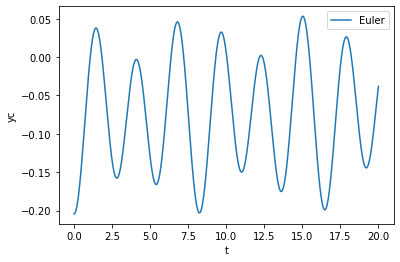

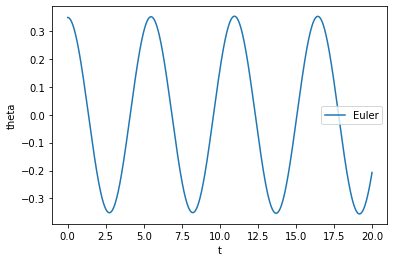

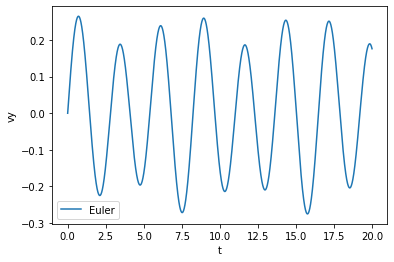

In [ ]:
#constants osv

##Task 2, parameters
def getGamma(theta, yc, beta = beta):        #beta: angel at equilibrium, theta: trivial, y_c: vertical displacement.
    return 2 * np.arccos(np.cos(beta/2) - 4/(3*np.pi) * (1 - np.cos(theta)) + yc/R)

def A(gamma):               #Area of immersed object
    return 1/2 * R**2 * (gamma - np.sin(gamma))

def F_B_2(gamma): #Overwriter tidliger F_B funksjon
    return A(gamma) * sigma_0 * g

def d_omega(gamma, theta):
    return - F_B_2(gamma) / I_C * h * np.sin(theta)

def a_y(gamma):
    return F_B_2(gamma) / m - g

def omega_vec_2(theta, omega, x, y, v_x, v_y):
    return np.array([theta, omega, x, y, v_x, v_y])

def f_sin_2(t, omega_vec, a_x = 0, beta = beta):
    gamma_num = getGamma(omega_vec[0], omega_vec[3] - yc_initial)
    return np.array([omega_vec[1], d_omega(gamma_num, omega_vec[0]), omega_vec[4], omega_vec[5], a_x, a_y(gamma_num)])

##task 2a) Solve 2a) through Eulers method
##Initial value:

theta_0 = np.radians(20)
omega_0 = 0

t_0 = 0
t_end = 20
t, omega_vec_2 = ode_solver(f_sin_2, t_0, t_end, omega_vec_2(theta_0, omega_0, 0, yc_initial, 0, 0), s)
print(yc_initial)
# Plot of the numerical solution
plot = True
if plot == True:
    plt.plot(t, np.transpose(omega_vec_2)[3], '-')


    plt.xlabel('t')
    plt.ylabel(f'yc')
    plt.legend(['Euler']);

    plt.show()

    plt.plot(t, np.transpose(omega_vec_2)[0], '-')
    

    plt.xlabel('t')
    plt.ylabel(f'theta')
    plt.legend(['Euler']);

    plt.show()

    plt.plot(t, np.transpose(omega_vec_2)[5], '-')
    

    plt.xlabel('t')
    plt.ylabel(f'vy')
    plt.legend(['Euler']);

    plt.show()

In [ ]:
##finalized ode_solver, 
def isDeath(omega_vec):
    if omega_vec[0] > (np.pi - getGamma(omega_vec[0], omega_vec[3] - yc_initial))/2:
        return True
    return False

In [ ]:
##task 2c)
def ode_solver_death(f, t0, tend, omega_vec_0, s, method = RK4):
    #Initializing:
    omega_vec_num = np.array([omega_vec_0])  # Array for the solution of omega_vec 
    t_num = np.array([t0])                     # Array for the t-values

    tn = t0                                    # Running values for t and array of omega_vec
    omega_vec_n = omega_vec_0 

    # Main loop
    while tn < tend - 1.e-10:                # Buffer for truncation errors   
        if tn + s > tend:
            s = tend - tn   

        if isDeath(omega_vec_n) == False:
            tn, omega_vec_n = method(f, tn, omega_vec_n, s)    # Do one step by the given methode
            
            # Extend the arrays for t and omega_vec
            omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
            t_num = np.append(t_num,tn)


        elif isDeath(omega_vec_n) == True:
            omega_vec_n = [np.sign(omega_vec_n[0]) * np.pi/2, 0, 0, 0, 0, 0]
            omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
            tn = tn + s
            t_num = np.append(t_num,tn)
    return t_num, omega_vec_num


In [ ]:
t_0 = 0
t_end = 20
theta_0 = 0
yc_initial = R * np.cos(beta/2) - h

def omega_vec(theta, omega, x, y, v_x, v_y):
    return np.array([theta, omega, x, y, v_x, v_y])

def f_sin(t, omega_vec, a_x = 0, beta = beta):
    gamma_num = getGamma(omega_vec[0], omega_vec[3] - yc_initial)
    return np.array([omega_vec[1], d_omega(gamma_num, omega_vec[0]), omega_vec[4], omega_vec[5], a_x, a_y(gamma_num)])

def bisection(omega_a, omega_b, tol=1.e-6, max_iter = 100, k = 0):
    print(k)
    t_a, omega_vec_a = ode_solver_death(f_sin, t_0, t_end, omega_vec(theta_0, omega_a, 0, yc_initial, 0, 0), s)
    t_b, omega_vec_b = ode_solver_death(f_sin, t_0, t_end, omega_vec(theta_0, omega_b, 0, yc_initial, 0, 0), s)

    death_a = -1
    death_b = -1

    if np.transpose(omega_vec_a)[-1][-1] == 0:
        death_a = 1
    if np.transpose(omega_vec_b)[-1][-1] == 0:
        death_b = 1

    assert death_a * death_b<0, 'Error: f(a)*f(b)>0, there may be no root in the interval.'

    
    while True:
        omega_c = 1/2 * (omega_a + omega_b)                 # The midpoint

        t_c, omega_vec_c = ode_solver_death(f_sin, t_0, t_end, omega_vec(theta_0, omega_c, 0, yc_initial, 0, 0), s)

        death_c = -1

        if np.transpose(omega_vec_c)[-1][-1] == 0:
            death_c = 1

        if omega_b-omega_a < tol:     # The zero is found!
            break 
        elif death_a*death_c < 0:                                  # There is a root in [omega_a, omega_c]
            return bisection(omega_a, omega_c, k = k + 1)
        else:                                                      # There is a root in [omega_c, omega_b]  
            return bisection(omega_c, omega_b, k= k + 1)

    return omega_c, k


smallest_omega, k = bisection(0.41, 0.45)

print(smallest_omega, "found after", k, "steps")

0
1
2
3
4
5
6
7


KeyboardInterrupt: 

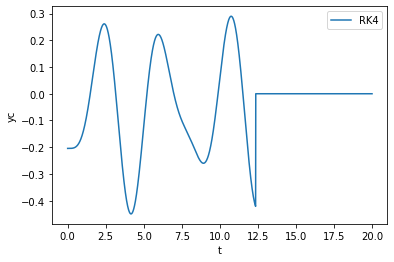

In [ ]:
t_death, omega_vec_death = ode_solver_death(f_sin, t_0, t_end, omega_vec(theta_0, smallest_omega, 0, yc_initial, 0, 0), s)

plot = True
if plot == True:
    plt.plot(t_death, np.transpose(omega_vec_death)[3], '-')


    plt.xlabel('t')
    plt.ylabel(f'yc')
    plt.legend(['RK4']);

    plt.show()

In [ ]:
def ode_solver_final(f, t0, tend, omega_vec_0, s, method = RK4, load = False, fence = False):
    #Initializing:
    omega_vec_num = np.array([omega_vec_0])  # Array for the solution of omega_vec 
    t_num = np.array([t0])                     # Array for the t-values
    time = -1

    tn = t0                                    # Running values for t and array of omega_vec
    omega_vec_n = omega_vec_0 

    # Main loop
    while tn < tend - 1.e-10:                # Buffer for truncation errors   
        if tn + s > tend:
            s = tend - tn   

        if isDeath(omega_vec_n) == False:
            tn, omega_vec_n = method(f, tn, omega_vec_n, s)    # Do one step by the given methode
                
            # Extend the arrays for t and omega_vec
            omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
            t_num = np.append(t_num,tn)


        elif isDeath(omega_vec_n) == True:
            omega_vec_n = [np.sign(omega_vec_n[0]) * np.pi/2, 0, 0, 0, 0, 0]
            omega_vec_num = np.concatenate((omega_vec_num, np.array([omega_vec_n])))
            tn = tn + s
            t_num = np.append(t_num,tn)
        
        if load == True and fence == False:            
            if abs(omega_vec_n[6]) > R:
                f = f_wo_l
                time = tn
        
        if load == True and fence == True:
            if abs(omega_vec_n[6]) > R:
                omega_vec_n[7] = 0
                f = f_l_fence
        
    return t_num, omega_vec_num

In [ ]:
m_l = 0.08 * m
 
sigma_l = sigma + m_l / A_s

def g_beta_l(beta):
    return np.pi * sigma_l / sigma_0 + np.sin(beta)

beta_l, numberOfSteps_l = fixedpoint(g_beta_l)

yc_initial_l = R * np.cos(beta_l/2) - h

def getGamma(theta, yc, beta = beta_l):        #beta: angel at equilibrium, theta: trivial, y_c: vertical displacement.
    return 2 * np.arccos(np.cos(beta/2) - 4/(3*np.pi) * (1 - np.cos(theta)) + yc/R)

def A_l(gamma):               #Area of immersed object
    return 1/2 * R**2 * (gamma - np.sin(gamma))

def F_B_l(gamma):
    return A_l(gamma) * sigma_0 * g

def d_omega_l(gamma, theta, s_l):
    return - F_B_l(gamma) / I_C * h * np.sin(theta) - m_l / I_C * g * np.cos(theta) * s_l

def a_y_l(gamma, theta):
    return F_B_l(gamma) / m - m_l / m * g * np.cos(theta)**2 - g

def a_x_l(theta):
    return m_l / m * g * np.cos(theta) * np.sin(theta)

def omega_vec_l(theta, omega, x, y, v_x, v_y, s_l, v_l):
    return np.array([theta, omega, x, y, v_x, v_y, s_l, v_l])

def a_l(theta):
    return - g * np.sin(theta)

def f_l(t, omega_vec, beta = beta_l):
    gamma_num = getGamma(omega_vec[0], omega_vec[3] - yc_initial_l)
    return np.array([omega_vec[1], d_omega_l(gamma_num, omega_vec[0], omega_vec[6]), omega_vec[4], omega_vec[5], a_x_l(omega_vec[0]), a_y_l(gamma_num, omega_vec[0]), omega_vec[7], a_l(omega_vec[0])])

def f_wo_l(t, omega_vec, beta = beta):
    gamma_num = getGamma(omega_vec[0], omega_vec[3] - yc_initial)
    return np.array([omega_vec[1], d_omega(gamma_num, omega_vec[0]), omega_vec[4], omega_vec[5], 0, a_y(gamma_num), 0, 0])

def f_l_fence(t, omega_vec, beta = beta):
    gamma_num = getGamma(omega_vec[0], omega_vec[3] - yc_initial)
    return np.array([omega_vec[1], d_omega_l(gamma_num, omega_vec[0], omega_vec[6]), omega_vec[4], omega_vec[5], a_x_l(omega_vec[0]), a_y_l(gamma_num, omega_vec[0]), 0, 0])


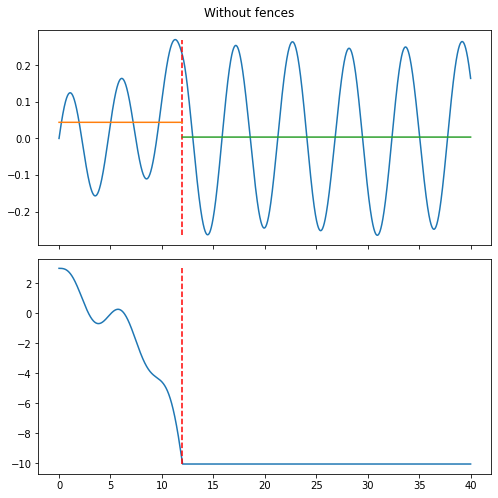

In [ ]:
t0 = 0
tend = 40
theta0 = 0
omega0 = 0.2
s_l0 = 3
v_l = 0

s = 0.01

omega_vec_initial = omega_vec_l(theta0, omega0, 0, yc_initial_l, 0, 0, s_l0, v_l)

t, omega_vec = ode_solver_final(f_l, t0, tend, omega_vec_initial, s, load = True, fence = False)

s_l = np.transpose(omega_vec)[6]
theta = np.transpose(omega_vec)[0]

index_t_drop = np.argmax(s_l < -R)


index_t_drop = index_t_drop

t_drop = index_t_drop * s

mean_with_load = np.full(index_t_drop, np.mean(theta[:index_t_drop]))
mean_without_load = np.full(len(t[index_t_drop: len(t)]), np.mean(theta[index_t_drop:]))

fig, (ax1, ax2) = plt.subplots(2, sharex= True)
fig.suptitle('Without fences')
fig.set_figheight(7)
fig.set_figwidth(7)

ax1.plot(t, theta)
ax1.vlines([t_drop], np.min(np.transpose(omega_vec)[0]), np.max(np.transpose(omega_vec)[0]) , linestyles='dashed', colors='red')
ax1.plot(t[:index_t_drop], mean_with_load)
ax1.plot(t[index_t_drop: len(t)], mean_without_load)

ax2.plot(t, s_l)
ax2.vlines([t_drop], np.min(np.transpose(omega_vec)[6]), np.max(np.transpose(omega_vec)[6]) , linestyles='dashed', colors='red')
fig.tight_layout(pad=1.0)


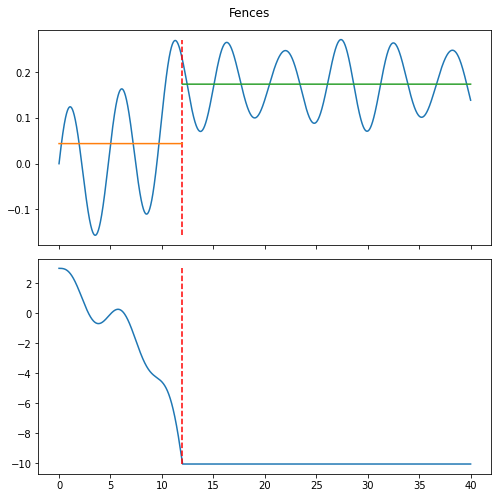

In [ ]:
t, omega_vec = ode_solver_final(f_l, t0, tend, omega_vec_initial, s, load = True, fence = True)

s_l = np.transpose(omega_vec)[6]
theta = np.transpose(omega_vec)[0]

index_t_drop = np.argwhere(abs(s_l) > R)
index_t_drop = index_t_drop[0][0]

t_drop = index_t_drop * s

mean_with_load = np.full(index_t_drop, np.mean(theta[:index_t_drop]))
mean_without_load = np.full(len(t[index_t_drop: len(t)]), np.mean(theta[index_t_drop:]))

fig, (ax1, ax2) = plt.subplots(2, sharex= True)
fig.suptitle('Fences')
fig.set_figheight(7)
fig.set_figwidth(7)

ax1.plot(t, theta)
ax1.vlines([t_drop], np.min(np.transpose(omega_vec)[0]), np.max(np.transpose(omega_vec)[0]) , linestyles='dashed', colors='red')
ax1.plot(t[:index_t_drop], mean_with_load)
ax1.plot(t[index_t_drop: len(t)], mean_without_load)

ax2.plot(t, s_l)
ax2.vlines([t_drop], np.min(np.transpose(omega_vec)[6]), np.max(np.transpose(omega_vec)[6]) , linestyles='dashed', colors='red')
fig.tight_layout(pad=1.0)

In [ ]:
##task 2e)
m_l = 0
M = m + m_l
sigma_l = sigma + m_l / A_s
omega_w = 0
F_0 = 0

def g_beta_l(beta):
    return np.pi * sigma_l / sigma_0 + np.sin(beta)

beta_l, numberOfSteps_l = fixedpoint(g_beta_l)

yc_initial_l = R * np.cos(beta_l/2) - h

def y_c(gamma, d_y_c, beta = beta_l):
    return R*np.cos(beta/2) - 4*R/(3 * np.pi) + d_y_c

##Forces

##F_x:
def lil_f(gamma, omega, k = k):
    return k * R * omega

def F_w(t, omega_w = omega_w, F_0 = F_0):
    return F_0 * np.cos(omega_w) * t

def F_lx(theta):
    return m_l * g * np.cos(theta) * np.sin(theta)

##F_y:
def F_ly(theta):
    return - m_l * g * np.cos(theta) ** 2

def F_B(gamma):                    #Overwriter tidliger F_B funksjon
    return A(gamma) * sigma_0 * g

F_g = - M * g

##a of load:
def a_l(theta):
    return - g * np.sin(theta)

##Torque

def T_B(theta, yc):
    return - F_B(getGamma(theta, yc)) * h * np.sin(theta)

def T_f(gamma, omega, d_y_c, k = k):
    return lil_f(gamma, omega) * (y_c(gamma, d_y_c) - (R * (np.cos(gamma/2) - 1)))

def T_w(gamma, d_y_c, F_0 = F_0, omega_w = omega_w):
    return F_w(0) * y_c(gamma, d_y_c)

def T_L(theta, s_l):
    return - m_l * g * np.cos(theta) * s_l


def get_d_omega(theta, omega, gamma, s_l, yc, F_0 = F_0, omega_w = omega_w):
    d_y_c = yc - yc_initial_l
    return (T_B(theta, yc) + T_f(gamma, omega, d_y_c) + T_w(gamma, d_y_c) + T_L(theta, s_l)) * 1/I_C

def function(t, omega_vec, beta = beta_l):
    gamma_num = getGamma(omega_vec[0], omega_vec[1], omega_vec[3] - yc_initial_l)
    
    ax = (lil_f(gamma_num, omega_vec[1]) + F_w(t) + F_lx(omega_vec[0])) / M

    ay = F_ly(omega_vec[0]) + F_B(gamma_num) + F_G / M

    d_omega = get_d_omega(omega_vec[0], omega_vec[1], gamma_num, omega_vec[6], omega_vec[3])

    al = a_l(omega_vec[0])

    ##print(np.array([omega_vec[1], d_omega, omega_vec[4], omega_vec[5], ax, ay, omega_vec[7], al]))
    
    return np.array([omega_vec[1], d_omega, omega_vec[4], omega_vec[5], ax, ay, omega_vec[7], al])


[ 0.         0.4        0.        -0.2044043  0.         0.
  0.         0.       ]
[ 0.4                nan  0.          0.          0.00081487         nan
  0.         -0.        ]
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arccos
  del sys.path[0]


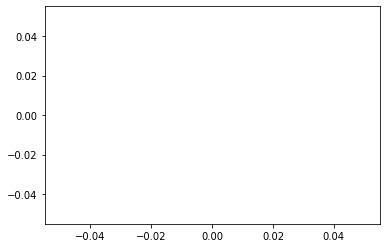

In [ ]:
##Initial values:
t0 = 0
tend = 40
s = 0.01

theta0 = 0
omega0 = 0.4

k = 0.0001

F_0 = 0
omega_w = 0

omega_vec_0 = np.array([theta0, omega0, 0, yc_initial_l, 0, 0, 0, 0])
print(omega_vec_0)
print(function(t0, omega_vec_0))

##T_B(theta, yc) + T_f(gamma, omega, d_y_c) + T_w(gamma, d_y_c) + T_L(theta, s_l)


print()

t, omega_vec = ode_solver_final(function, t0, tend, omega_vec_0, s, load = True, fence = True)

plt.figure()
plt.plot(t, np.transpose(omega_vec)[0])
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ab191a1-09a5-408e-bc60-9f55ed89e002' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>